In [9]:
import numpy as np
from library_dicom.dicom_processor.tools.create_mip import mip_imshow, mip_projection
import matplotlib.pyplot as plt
#from radiomics.featureextractor import *
from sklearn import mixture
import SimpleITK as sitk
from PIL import Image

from library_dicom.post_processing.PostProcess_Reader import PostProcess_Reader
from library_dicom.post_processing.Mask4D import Mask4D
from library_dicom.post_processing.WatershedModel import WatershedModel 
from library_dicom.dicom_processor.tools.folders import *
from library_dicom.dicom_processor.tools.threshold_mask import *
from library_dicom.dicom_processor.tools.postprocessing import *
import csv

In [2]:
#predictions 

pred_1 = os.listdir('/media/deeplearning/Elements/train')
pred_2 = os.listdir('/media/deeplearning/Elements/val')

pred = pred_1 + pred_2

study_uid = []

for item in pred_1 : 
    subliste = []
    subliste.append(item.split('_')[0]) 
    subliste.append('train')
    study_uid.append(subliste)

for item in pred_2 : 
    subliste = []
    subliste.append(item.split('_')[0]) 
    subliste.append('val')
    study_uid.append(subliste)


#charger csv agl, gained, flip 
csv_ahl=  '/media/deeplearning/Elements/AHL2011_NIFTI.csv'

with open(csv_ahl, 'r') as csv_file :
    reader = csv.reader(csv_file, delimiter = ',') #liste pour chaque ligne 
    data_ahl = []
    for row in reader :
        data_ahl.append(row)
        
del data_ahl[0] #enlever première ligne
 




csv_gained= '/media/deeplearning/78ca2911-9e9f-4f78-b80a-848024b95f92/GAINED_NIFTI/GAINED_PET0_NIFTI.csv'

with open(csv_gained, 'r') as csv_file :
    reader = csv.reader(csv_file, delimiter = ',') #liste pour chaque ligne 
    data_gained = []
    for row in reader :
        data_gained.append(row)
        
del data_gained[0] #enlever première ligne



csv_flip= '/media/deeplearning/78ca2911-9e9f-4f78-b80a-848024b95f92/FLIP_NIFTI/FLIP_PET0_NIFTI.csv'

with open(csv_flip, 'r') as csv_file :
    reader = csv.reader(csv_file, delimiter = ',') #liste pour chaque ligne 
    data_flip = []
    for row in reader :
        data_flip.append(row)
        
del data_flip[0] #enlever première ligne

In [3]:
len(study_uid)

1005

In [4]:
study_uid[0]

['1.2.276.0.7230010.3.2.138382', 'train']

In [5]:
#find associated serie nifti 
dataset = []
for item in study_uid : 
    subliste = []
    subliste.append(item[0])
    subliste.append(item[1])
    for ahl in data_ahl : 
        if item[0] in ahl : 
            subliste.append(ahl[1]) #patient id 
            subliste.append(ahl[5]) #pet
            subliste.append(ahl[6]) #mask
            subliste.append('AHL')
            dataset.append(subliste)
        
    for gained in data_gained : 
        if item[0] in gained : 
            subliste.append(gained[0]) #patient id 
            subliste.append(gained[4]) #pet
            subliste.append(gained[5]) #mask 
            subliste.append('GAINED')
            dataset.append(subliste)

    for flip in data_flip : 
        if item[0] in flip : 
            subliste.append(flip[1]) #patient id 
            subliste.append(flip[5]) #pet
            subliste.append(flip[6]) #mask 
            subliste.append('FLIP')
            dataset.append(subliste)


In [6]:
len(dataset)

1005

In [7]:
dataset[0]

['1.2.276.0.7230010.3.2.138382',
 'train',
 '13011101031031',
 '/media/storage/AHL2011_NIFTI/1.2.276.0.7230010.3.2.138382_nifti_PT.nii',
 '/media/storage/AHL2011_NIFTI/1.2.276.0.7230010.3.2.138382_nifti_mask.nii',
 'AHL']

In [8]:
#include prediction 
for serie in dataset : 
    for prediction in pred :
        if serie[0] in prediction : 
            serie.append(prediction)
            break

In [9]:
dataset[0]

['1.2.276.0.7230010.3.2.138382',
 'train',
 '13011101031031',
 '/media/storage/AHL2011_NIFTI/1.2.276.0.7230010.3.2.138382_nifti_PT.nii',
 '/media/storage/AHL2011_NIFTI/1.2.276.0.7230010.3.2.138382_nifti_mask.nii',
 'AHL',
 '1.2.276.0.7230010.3.2.138382_mask_pred_float.nii']

In [8]:
for serie in dataset : 
    if len(serie) != 7 : 
        print(serie)

In [10]:
#rewrite path for ahl and relative path for pred
for serie in dataset : 
    if 'AHL' in serie : 
        txt = serie[3].replace('storage', 'deeplearning/Elements')
        serie[3] = txt 

        txt_2 = serie[4].replace('storage', 'deeplearning/Elements')
        serie[4] = txt_2 

    if 'train' in serie : 
        path = '/media/deeplearning/Elements'+'/'+'train'+'/'+serie[-1]
        serie[-1] = path 

    else : 
        path = '/media/deeplearning/Elements'+'/'+'val'+'/'+serie[-1]
        serie[-1] = path 



In [11]:
dataset[0]

['1.2.276.0.7230010.3.2.138382',
 'train',
 '13011101031031',
 '/media/deeplearning/Elements/AHL2011_NIFTI/1.2.276.0.7230010.3.2.138382_nifti_PT.nii',
 '/media/deeplearning/Elements/AHL2011_NIFTI/1.2.276.0.7230010.3.2.138382_nifti_mask.nii',
 'AHL',
 '/media/deeplearning/Elements/train/1.2.276.0.7230010.3.2.138382_mask_pred_float.nii']

In [12]:
#write csv 
nifti_directory = '/media/deeplearning/78ca2911-9e9f-4f78-b80a-848024b95f92/post_processing/pred_2'

with open(os.path.join(nifti_directory, 'dataset_post_processing_pred2.csv'), 'w') as csv_file : 
    csv_writer = csv.writer(csv_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    csv_writer.writerow(["PATIENT ID", "STUDY UID", "NIFTI_PET", "NIFTI_MASK", "PRED_MASK", "TYPE", "STUDY"])
    for serie in dataset:
        csv_writer.writerow([serie[2], serie[0], serie[3], serie[4], serie[6], serie[1], serie[5]])  

In [2]:
#read csv 
csv_ahl_post_process= '/media/deeplearning/78ca2911-9e9f-4f78-b80a-848024b95f92/post_processing/pred_2/dataset_post_processing_pred2.csv'

with open(csv_ahl_post_process, 'r') as csv_file :
    reader = csv.reader(csv_file, delimiter = ',') #liste pour chaque ligne 
    dataset = []
    for row in reader :
        dataset.append(row)
        
del dataset[0] #enlever première ligne

In [3]:
dataset[0]

['13011101031031',
 '1.2.276.0.7230010.3.2.138382',
 '/media/deeplearning/Elements/AHL2011_NIFTI/1.2.276.0.7230010.3.2.138382_nifti_PT.nii',
 '/media/deeplearning/Elements/AHL2011_NIFTI/1.2.276.0.7230010.3.2.138382_nifti_mask.nii',
 '/media/deeplearning/Elements/train/1.2.276.0.7230010.3.2.138382_mask_pred_float.nii',
 'train',
 'AHL']

In [26]:
#generate 2 images 
directory = '/media/deeplearning/78ca2911-9e9f-4f78-b80a-848024b95f92/post_processing/pred_2/mip'
print(dataset[439])
#print(dataset[302])
#print(dataset[310])

['11011101211023', '1.3.51.0.1.1.10.49.10.222.2814261.2813142', '/media/deeplearning/78ca2911-9e9f-4f78-b80a-848024b95f92/GAINED_NIFTI/11011101211023/pet0/1.3.51.0.1.1.10.49.10.222.2814261.2813142_nifti_PT.nii', '/media/deeplearning/78ca2911-9e9f-4f78-b80a-848024b95f92/GAINED_NIFTI/11011101211023/pet0/1.3.51.0.1.1.10.49.10.222.2814261.2813142_nifti_mask.nii', '/media/deeplearning/Elements/train/1.3.51.0.1.1.10.49.10.222.2814261.2813142_mask_pred_float.nii', 'train', 'GAINED']


In [64]:
#generate nifti ws 
from library_dicom.dicom_processor.tools.generate_nifti import *
serie = dataset[687]
serie[4] = serie[4].replace('Elements', '78ca2911-9e9f-4f78-b80a-848024b95f92')
print(serie[4])

model = WatershedModel(serie[4], serie[2], type = '3d')
ws_array, label_number = model.watershed_model(0.5)
filename = serie[1]+'_nifti_watershed.nii'
spacing = model.pet_spacing
direction = model.pet_direction
origin = model.pet_origin
generate_nifti(ws_array, origin, direction, spacing, os.path.join(directory, filename))

ws_array = get_threshold_matrix(ws_array, model.pet_array, label_number, 0.41)
filename_2 = serie[1]+'_nifti_watershed_seuil.nii'
generate_nifti(ws_array, origin, direction, spacing, os.path.join(directory, filename_2))



binary_img = model.get_binary_threshold_mask_img(0.5)
binary_array = model.remove_small_roi(binary_img)
filename_3 = serie[1] + '_nifti_binary.nii'
generate_nifti(binary_array, origin, direction, spacing, os.path.join(directory, filename_3))

/media/deeplearning/78ca2911-9e9f-4f78-b80a-848024b95f92/train/1.2.840.113619.2.290.3.1569943720.329.1411663296.387_mask_pred_float.nii


In [69]:
def transparent_1(myimage) : 
 
    img = Image.open(myimage) 
    img = img.convert("RGBA")
    datas = img.getdata()
    print(datas[0])
    newData = []
    for item in datas:
        #print(item)
        #if item[0] > 200 and item[1] > 200 and item[2] > 200:
        if item[0] < 88 and item[1] < 88  and item[2] < 88: #viridis
            newData.append((0, 0, 0, 0))
        else:
            newData.append(item)
 
    img.putdata(newData)
    img.save(myimage, "PNG") 
    return(myimage)


def superposer_img(mask,background, angle, study_uid, directory): # ft = front , bg = background
 
    mask = Image.open(mask, 'r')
    #filename1 = background
    background = Image.open(background, 'r')
    text_img = Image.new('RGBA', background.size , (0, 0, 0, 0))
    text_img.paste(background, (0,0))
    text_img.paste(mask, (0,0), mask=mask)
    text_img.save(directory+'/'+study_uid+'_watershed_seuil'+'_sup'+str(int(angle))+'.png', format="png")
    return directory+'/'+study_uid+'_'+'watershed'+'_sup'+str(int(angle))+'.png'


def create_mip_superpose_gif(numpy_array_mask, numpy_array_tep, directory, study_uid, cmap_mask, vmin=0, vmax=5):
    """return a gif of a numpy_array MIP 

    """
    duration = 0.1
    number_images = 60
    
    angle_filenames_tep = []
    angle_filenames_mask = []

    angle_filenames = []

    
    #angles = np.linspace(0, 360, number_images)
    angles = [90]
    for angle in angles:
        cmap_tep = 'Greys'
        vmin = 0
        vmax = 5
        path_tep = mip_projection(numpy_array_tep, angle, directory, study_uid, 'pet', cmap_tep, vmin, vmax)
        angle_filenames_tep.append(path_tep)

        path_mask = mip_projection(numpy_array_mask, angle, directory, study_uid,'mask', cmap_mask, vmin, vmax)
        angle_filenames_mask.append(path_mask)


        #mask transparant
        path_mask = transparent_1(path_mask)

        #superposition

        #angle_filenames.append(superposer_img(new_path_mask, path_tep, angle, study_uid))
        #os.remove(path_tep)
        #os.remove(new_path_mask)
        superposer_img(path_mask, path_tep, angle, study_uid, directory)


    #create_gif(angle_filenames, duration, directory)

    #for path in angle_filenames : 
        #os.remove(path)
       
    
    return None

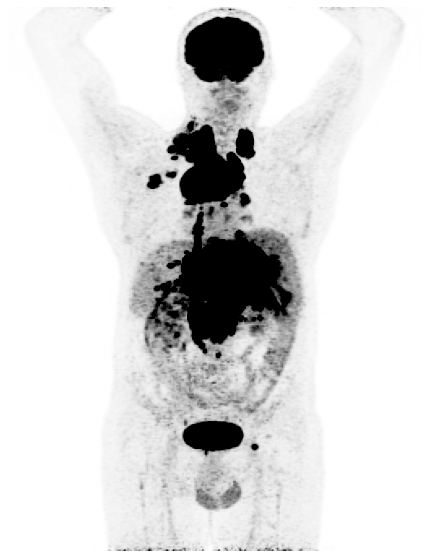

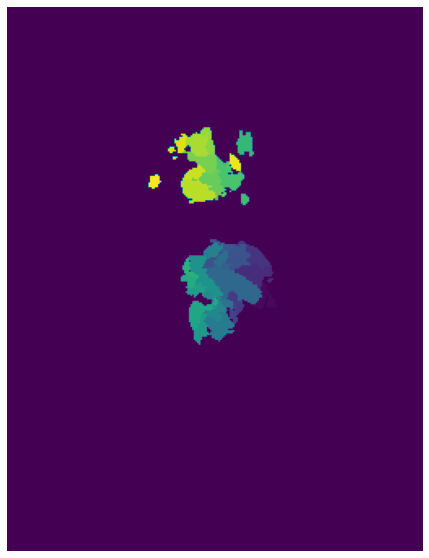

(255, 255, 255, 0)


In [70]:
#generate MIP 
tep_path = serie[2]
img_pet = sitk.ReadImage(tep_path)
pet_array = sitk.GetArrayFromImage(img_pet).transpose()
mip_imshow(pet_array, 90, cmap='Greys', type='pet', vmin=0, vmax=5)



mask_path = os.path.join(directory,serie[1]+'_nifti_watershed_seuil.nii')
img_mask = sitk.ReadImage(mask_path)
mask_array = sitk.GetArrayFromImage(img_mask)
mip_imshow(mask_array, 90, cmap='viridis', type='mask', vmin=2, vmax=15)

create_mip_superpose_gif(mask_array, pet_array, directory, serie[1], 'viridis', vmin=0, vmax=5)

In [15]:
results_directory = '/media/deeplearning/78ca2911-9e9f-4f78-b80a-848024b95f92/post_processing/pred_2'
error = []
#path_mip = []


for serie in dataset: 
    print(dataset.index(serie))
    subliste = []
    try : 
        model = WatershedModel(serie[4], serie[2], type = '3d')
        ws_array, label_number = model.watershed_model(0.5)


        volume_voxel = model.pet_spacing[0]*model.pet_spacing[1]*model.pet_spacing[2]*10**(-3) #ml 


        #VOLUME PREDICTION AVEC WATERSHED AFTER SEUIL 41%
        ws_array = get_threshold_matrix(ws_array, model.pet_array, label_number, 0.41)
        number_pixel = len(np.where(ws_array != 0)[0])
        vol_sous_seg_seuil = number_pixel * volume_voxel
        serie.append(vol_sous_seg_seuil)
        #tmtv.append(vol_sous_seg_seuil)
        print("VOL WITH WATERSHED OK")


        #VOLUME BINARY MASK 
        binary_img = model.get_binary_threshold_mask_img(0.5)
        binary_array = model.remove_small_roi(binary_img)

        number_pixel_binaire = len(np.where(binary_array != 0 )[0])
        vol_binaire = number_pixel_binaire * volume_voxel 
        serie.append(vol_binaire)
        print("VOL PRED OK ")

        #VOLUME TRUTH- 41%
        img_4d = sitk.ReadImage(serie[3])
        mask = sitk.GetArrayFromImage(img_4d).transpose()
        mask = get_threshold_matrix_4D(mask, model.pet_array, 0.41)

        if len(mask.shape) != 3 : 
            mask_sum = np.sum(mask, axis = -1)
        else : 
            mask_sum = mask 

        number_pixel_truth = len(np.where(mask_sum != 0)[0])
        vol_truth = number_pixel_truth * volume_voxel
        serie.append(vol_truth) 
        print("VOL TRUTH OK ")


        #here to write stats results from the watershed labelled 3D matrix
        #json_details = model.label_stat_results(img2)
        #tmtv.append(json_details['total_vol'])
        #write_json_file(folder, serie[1]+'_details', json_details)

        #can add method to save result as nifti 

    except Exception as err : 
        print(err)
        print(serie)
        error.append(serie)

VOL TRUTH OK 
628
VOL WITH WATERSHED OK
VOL PRED OK 
VOL TRUTH OK 
629
VOL WITH WATERSHED OK
VOL PRED OK 
VOL TRUTH OK 
630
VOL WITH WATERSHED OK
VOL PRED OK 
VOL TRUTH OK 
631
VOL WITH WATERSHED OK
VOL PRED OK 
VOL TRUTH OK 
632
VOL WITH WATERSHED OK
VOL PRED OK 
VOL TRUTH OK 
633
VOL WITH WATERSHED OK
VOL PRED OK 
VOL TRUTH OK 
634
VOL WITH WATERSHED OK
VOL PRED OK 
VOL TRUTH OK 
635
VOL WITH WATERSHED OK
VOL PRED OK 
VOL TRUTH OK 
636
VOL WITH WATERSHED OK
VOL PRED OK 
VOL TRUTH OK 
637
VOL WITH WATERSHED OK
VOL PRED OK 
VOL TRUTH OK 
638
VOL WITH WATERSHED OK
VOL PRED OK 
VOL TRUTH OK 
639
VOL WITH WATERSHED OK
VOL PRED OK 
VOL TRUTH OK 
640
VOL WITH WATERSHED OK
VOL PRED OK 
VOL TRUTH OK 
641
VOL WITH WATERSHED OK
VOL PRED OK 
VOL TRUTH OK 
642
VOL WITH WATERSHED OK
VOL PRED OK 
VOL TRUTH OK 
643
VOL WITH WATERSHED OK
VOL PRED OK 
VOL TRUTH OK 
644
VOL WITH WATERSHED OK
VOL PRED OK 
VOL TRUTH OK 
645
VOL WITH WATERSHED OK
VOL PRED OK 
VOL TRUTH OK 
646
VOL WITH WATERSHED OK
VOL PR

In [16]:
#write csv 
nifti_directory = '/media/deeplearning/78ca2911-9e9f-4f78-b80a-848024b95f92/post_processing/pred_2'

with open(os.path.join(nifti_directory, 'result_tmtv_sous_seg.csv'), 'w') as csv_file : 
    csv_writer = csv.writer(csv_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    csv_writer.writerow(["PATIENT ID", "STUDY UID", "NIFTI_PET", "NIFTI_MASK", "PRED_MASK", "TYPE", "STUDY", "VOL_TRUTH", "VOL_PRED", "VOL_WS"])
    for serie in dataset:
        csv_writer.writerow([serie[0], serie[1], serie[2], serie[3], serie[4], serie[5], serie[6], serie[-1], serie[-2], serie[-3]])  

In [ ]:
#Here, can add pourcent of difference between VOL_WS-41% and VOL_TRUTH , and plot the Bland Altmann result 

In [ ]:
#Open CSV with VOLUME result 
csv_ahl_post_process= '/media/deeplearning/78ca2911-9e9f-4f78-b80a-848024b95f92/post_processing/pred_2/result_tmtv_sous_seg.csv'

with open(csv_ahl_post_process, 'r') as csv_file :
    reader = csv.reader(csv_file, delimiter = ',') #liste pour chaque ligne 
    csv_data = []
    for row in reader :
        csv_data.append(row)
        
del csv_data[0] #enlever première ligne

In [ ]:
#calcul percentage of difference 
for row in csv_data : 
    vol_truth = float(row[-3])
    vol_ws = float(row[-1])
    diff = (vol_ws - vol_truth) / vol_truth * 100 

    row.append(diff)

In [ ]:
#Get liste of all volume and percentage, only on vol_prediction bigger than volume_truth , compteur cpt to count it 
truth = []
sous_seg = []
pourcent = []
pred = []
cpt = 0
for row in csv_data : 
    if float(row[-3]) > float(row[-4]) : #if vol pred > vol truth
        cpt += 1 
        truth.append(float(row[-4]))
        sous_seg.append(float(row[-2]))
        pourcent.append(float(row[-1]))
        pred.append(float(row[-3]))

print(cpt)
print(len(truth))
print(len(sous_seg))
print(len(pourcent))
print(len(pred))

In [ ]:
#Bland Altmann plot 
mean = []
diff = []
for i in range(len(truth)):
    subliste = []
    subliste.append(truth[i])
    subliste.append(sous_seg[i])
    mean.append(np.mean(subliste))

    diff.append(truth[i] - sous_seg[i])

#y = pourcent 
f = plt.figure(figsize=(8,5))
axes = plt.gca()
moy = np.mean(pourcent)
sd = np.std(pourcent)
print(moy)
print(sd)
plt.axhline(moy, c='r', label='mean', linewidth=3)
plt.axhline(moy + 2*sd, c='green', label = 'm + 2sd' )
plt.axhline(moy - 2*sd, c='green', label = 'm - 2sd' )
plt.axhline(0, c='black', linestyle='--',label = '0' )
plt.axhline(20, c='blue',label = '20%', linestyle='dashdot' )
plt.axhline(-20, c='blue',label = '-20%' ,linestyle='dashdot' )
plt.scatter(mean, pourcent, alpha=0.6)
plt.ylim(-200, 300)
plt.xlabel('mean')
plt.ylabel('pourcent diff')
plt.legend()
plt.title('Bland Altman after watershed')

#y = difference
f = plt.figure(figsize=(8,5))
axes = plt.gca()
moy = np.mean(diff)
sd = np.std(diff)
print(moy)
print(sd)
plt.axhline(moy, c='r', label='mean', linewidth=3)
plt.axhline(moy + 2*sd, c='green', label = 'm + 2sd' )
plt.axhline(moy - 2*sd, c='green', label = 'm - 2sd' )
plt.scatter(mean, diff, alpha=0.6)
#plt.xlim(0, 500)
plt.xlabel('mean')
plt.ylabel('diff')
plt.legend()
plt.title('Bland Altman after watershed')


#linear regression 
from scipy import stats
#linregress() renvoie plusieurs variables de retour. On s'interessera 
# particulierement au slope et intercept
slope, intercept, r_value, p_value, std_err = stats.linregress(truth, sous_seg)

def regression(x, slope, intercept):
    y = []
    for i in range(len(x)):
        y.append(slope * x[i] + intercept)

    return y 


f = plt.figure(figsize=(8,5))
axes = plt.gca()
plt.scatter(truth, sous_seg, alpha=0.6)
plt.plot(truth, regression(truth, slope, intercept), c='green', label='regression lin')
plt.plot([0,2300], [0,2300], 'r--', label='x=y')
plt.xlabel('truth')
plt.ylabel('sous_seg')